# Dogs vs. Cats Image Classification

## Import Libraries

In [1]:
from glob import iglob
import shutil
import os
import gc

from fastai.vision.all import *

In [2]:
# Clear the working folder
!rm -rf /kaggle/working/*

## Import Images

In [3]:
# Unzip the train folder
! unzip "/kaggle/input/dogs-vs-cats/train.zip" 

# Unzip the test folder
! unzip "/kaggle/input/dogs-vs-cats/test1.zip"     

Archive:  /kaggle/input/dogs-vs-cats/train.zip
   creating: train/
  inflating: train/cat.0.jpg         
  inflating: train/cat.1.jpg         
  inflating: train/cat.10.jpg        
  inflating: train/cat.100.jpg       
  inflating: train/cat.1000.jpg      
  inflating: train/cat.10000.jpg     
  inflating: train/cat.10001.jpg     
  inflating: train/cat.10002.jpg     
  inflating: train/cat.10003.jpg     
  inflating: train/cat.10004.jpg     
  inflating: train/cat.10005.jpg     
  inflating: train/cat.10006.jpg     
  inflating: train/cat.10007.jpg     
  inflating: train/cat.10008.jpg     
  inflating: train/cat.10009.jpg     
  inflating: train/cat.1001.jpg      
  inflating: train/cat.10010.jpg     
  inflating: train/cat.10011.jpg     
  inflating: train/cat.10012.jpg     
  inflating: train/cat.10013.jpg     
  inflating: train/cat.10014.jpg     
  inflating: train/cat.10015.jpg     
  inflating: train/cat.10016.jpg     
  inflating: train/cat.10017.jpg     
  inflating: train/ca

In [4]:
# Split files into dog and cat images using filenames and move them into respective folders

train_dir = "/kaggle/working/train/"
        
os.makedirs('/kaggle/working/train/train/cats/')
os.makedirs('/kaggle/working/train/train/dogs/')


cat_train_dir = "/kaggle/working/train/train/cats/"
dog_train_dir = "/kaggle/working/train/train/dogs/"


# Move cat files into cats folder
for jpgfile in iglob(os.path.join(train_dir, "cat*.jpg")):
    filename = os.path.basename(jpgfile)
    parts = filename.split('.')
    if len(parts) > 1 and parts[0] == 'cat':  
        shutil.copy(jpgfile, cat_train_dir)

# Move dog files into dogs folder
for jpgfile in iglob(os.path.join(train_dir, "dog*.jpg")):
    filename = os.path.basename(jpgfile)
    parts = filename.split('.')
    if len(parts) > 1 and parts[0] == 'dog':  
        shutil.copy(jpgfile, dog_train_dir)

In [5]:
train_path = Path('/kaggle/working/train/train')
test_path = Path('/kaggle/working/test1')

In [6]:
fns = get_image_files(train_path)
fns

(#25000) [Path('/kaggle/working/train/train/dogs/dog.11567.jpg'),Path('/kaggle/working/train/train/dogs/dog.8506.jpg'),Path('/kaggle/working/train/train/dogs/dog.11986.jpg'),Path('/kaggle/working/train/train/dogs/dog.3317.jpg'),Path('/kaggle/working/train/train/dogs/dog.11058.jpg'),Path('/kaggle/working/train/train/dogs/dog.8603.jpg'),Path('/kaggle/working/train/train/dogs/dog.2369.jpg'),Path('/kaggle/working/train/train/dogs/dog.8730.jpg'),Path('/kaggle/working/train/train/dogs/dog.2292.jpg'),Path('/kaggle/working/train/train/dogs/dog.8173.jpg')...]

### Create a DataLoader for the Training Set

In [7]:
cats_dogs = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128))

### Data Augmentation

In [8]:
cats_dogs = cats_dogs.new(item_tfms=Resize(224), batch_tfms=aug_transforms(mult=2))
dls = cats_dogs.dataloaders(train_path)

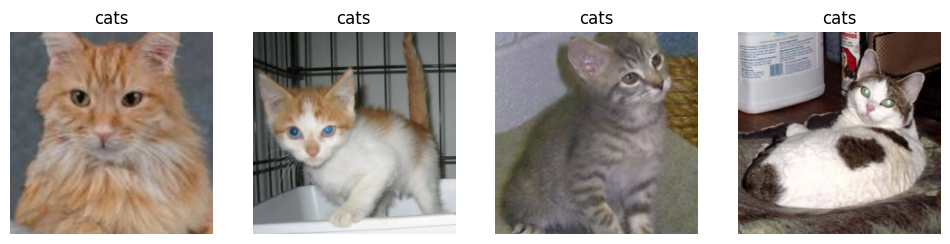

In [9]:
dls.valid.show_batch(max_n=4, nrows=1)

## Train the Model

In [10]:
# Create a Learner using ResNet18 model and finetune it

learn = vision_learner(dls, resnet18, metrics=[accuracy, error_rate])
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 93.6MB/s]


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.148016,0.057578,0.979800,0.020200,00:53


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.085704,0.040919,0.983600,0.016400,00:55
1,0.058413,0.034462,0.989400,0.010600,01:02
2,0.037881,0.031458,0.988800,0.011200,01:04


## Create a Confusion Matrix

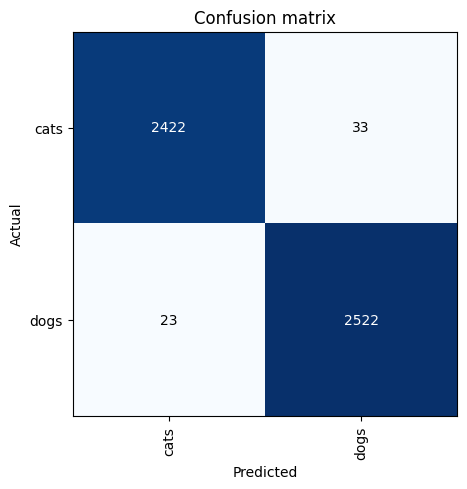

In [11]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

#### Check the Images with Highest Losses

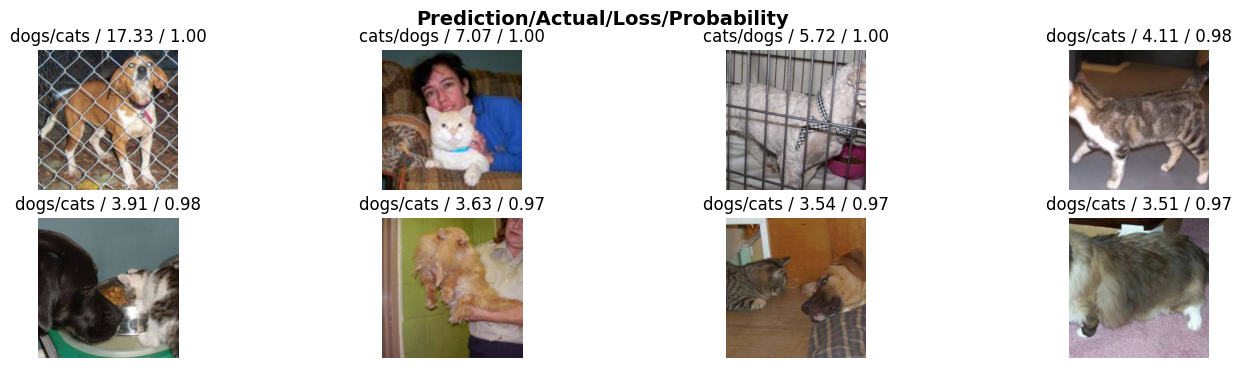

In [12]:
interp.plot_top_losses(8, nrows=2, figsize = (17,4))

### Create a Test DataLoader

## Predict the Test Results

In [13]:
# Define the test Path
test_path = Path(test_path)

# Create a test DataLoader
test_dl = learn.dls.test_dl(get_image_files(test_path), 
                            item_tfms = Resize(224),
                            batch_tfms = aug_transforms(mult=2))

In [14]:
# Predict for the test data
preds, _ = learn.get_preds(dl=test_dl)

# Get the predicted class indices
pred_class_indices = preds.argmax(dim=1)

# Convert it to a numpy array
pred_np = pred_class_indices.cpu().numpy()


In [15]:
pred_np

array([1, 0, 1, ..., 0, 0, 0])